In [146]:
%pylab inline

from collections import Counter
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import pandas as pd

from soln.dataset import AllCategoricalsFeaturizer
from soln.dataset import generate_xv_splits
from soln.dataset import get_augmented_train_and_test_set
from soln.dataset import log_transform_y
from soln.bracket import brapa
from soln.bracket import fc_vals
from soln.bracket import generate_bracket_csv
from soln.utils import eval_regressor
from soln.utils import print_brackets
from soln.utils import print_feature_importances

Populating the interactive namespace from numpy and matplotlib


In [3]:
%time aug_train_set, aug_test_set = get_augmented_train_and_test_set()

CPU times: user 6.48 s, sys: 100 ms, total: 6.58 s
Wall time: 6.66 s


In [4]:
%time generate_bracket_csv(aug_train_set)

CPU times: user 6.43 s, sys: 16 ms, total: 6.44 s
Wall time: 6.47 s


In [6]:
bracket = pd.read_csv('bracket.csv')
print bracket.shape
bracket[:5]

(2205, 4)


,tube_assembly_id,fixed_cost_class,fixed_cost,var_cost
0,TA-18908,1,19.043385,2.764790
1,TA-18906,1,19.043385,2.868769
2,TA-18907,1,19.043385,3.430745
3,TA-18902,1,19.043385,1.759423
4,TA-18903,1,19.043385,1.825497


In [60]:
# Check that if we know the true fixed_cost and var_cost,
# we can recover the total cost with tiny error.
print aug_train_set.shape
df = aug_train_set[aug_train_set.bracketing_pattern == brapa]
print df.bracketing_pattern.value_counts()
print df.shape
df = df.merge(bracket, on='tube_assembly_id')
print df.shape
df['pred_cost'] = df['fixed_cost'] / df['adj_quantity'] + df['var_cost']
df['pred_log_cost'] = log_transform_y(df['pred_cost'])
print np.sqrt(mean_squared_error(df.log_cost, df.pred_log_cost))
df['err2'] = (df.log_cost - df.pred_log_cost) ** 2
print df.err2.describe()
df.sort('err2', ascending=False, inplace=True)
df[:10]

(30213, 30)
(1, 2, 5, 10, 25, 50, 100, 250)    17640
dtype: int64
(17640, 30)
(17640, 33)
0.0103660178673
count    1.764000e+04
mean     1.074543e-04
std      1.710715e-04
min      4.519863e-09
25%      1.856582e-06
50%      3.797760e-05
75%      1.439752e-04
max      1.383129e-03
Name: err2, dtype: float64


,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,log_cost,material_id,diameter,...,adj_quantity,adj_bracketing,bracketing_pattern,dev_fold,fixed_cost_class,fixed_cost,var_cost,pred_cost,pred_log_cost,err2
16167,TA-20557,S-0066,2013-12-02,1,0,True,250,0.864718,SP-0029,19.05,...,250,True,"(1, 2, 5, 10, 25, 50, 100, 250)",8,0,15.704975,1.224836,1.287656,0.827528,0.001383
16351,TA-20621,S-0066,2013-12-02,1,0,True,250,0.849369,SP-0029,19.05,...,250,True,"(1, 2, 5, 10, 25, 50, 100, 250)",4,0,15.704975,1.190408,1.253228,0.812364,0.001369
759,TA-00688,S-0066,2013-07-28,0,0,True,250,0.898134,SP-0028,6.35,...,250,True,"(1, 2, 5, 10, 25, 50, 100, 250)",8,1,19.043385,1.291690,1.367863,0.861988,0.001307
15319,TA-20246,S-0066,2013-08-01,0,0,True,250,0.884442,SP-0039,9.52,...,250,True,"(1, 2, 5, 10, 25, 50, 100, 250)",6,1,19.043385,1.260739,1.336913,0.848831,0.001268
13071,TA-18947,S-0066,2013-04-14,0,0,True,250,0.917215,SP-0039,12.70,...,250,True,"(1, 2, 5, 10, 25, 50, 100, 250)",4,1,19.043385,1.338985,1.415158,0.881765,0.001257
17343,TA-20992,S-0066,2013-09-01,0,0,True,250,0.921652,SP-0019,4.76,...,250,True,"(1, 2, 5, 10, 25, 50, 100, 250)",6,1,19.043385,1.350113,1.426286,0.886362,0.001245
17607,TA-21085,S-0066,2013-08-04,0,0,True,250,0.901528,SP-0029,6.35,...,250,True,"(1, 2, 5, 10, 25, 50, 100, 250)",0,1,19.043385,1.301775,1.377948,0.866238,0.001245
16175,TA-20558,S-0066,2013-12-02,1,0,True,250,0.903784,SP-0029,19.05,...,250,True,"(1, 2, 5, 10, 25, 50, 100, 250)",2,0,15.704975,1.321165,1.383985,0.868774,0.001226
9407,TA-08661,S-0066,2013-12-02,1,0,True,250,0.906035,SP-0029,22.22,...,250,True,"(1, 2, 5, 10, 25, 50, 100, 250)",7,0,15.704975,1.327077,1.389897,0.871250,0.001210
17567,TA-21056,S-0066,2013-06-30,0,0,True,250,0.935939,SP-0019,6.35,...,250,True,"(1, 2, 5, 10, 25, 50, 100, 250)",7,1,19.043385,1.386280,1.462453,0.901158,0.001210


In [39]:
# Get train and test set only for the well-behaved bracket.

X_train, y_train, X_test, y_test = next(generate_xv_splits(aug_train_set))
X_train['log_cost'] = y_train
X_test['log_cost'] = y_test
print X_train.shape, X_test.shape

X_train = X_train[X_train.bracketing_pattern == brapa]
X_test = X_test[X_test.bracketing_pattern == brapa]
print X_train.shape, X_test.shape

y_train = X_train.pop('log_cost')
y_test = X_test.pop('log_cost')

print X_train.bracketing_pattern.value_counts()
print X_test.bracketing_pattern.value_counts()
print X_train.supplier.value_counts()
print X_test.supplier.value_counts()

(27270, 29) (2943, 29)
(15992, 29) (1648, 29)
(1, 2, 5, 10, 25, 50, 100, 250)    15992
dtype: int64
(1, 2, 5, 10, 25, 50, 100, 250)    1648
dtype: int64
S-0066    15992
dtype: int64
S-0066    1648
dtype: int64


In [40]:
# Evaluate original RF on the well-behaved bracket.

featurizer = AllCategoricalsFeaturizer()
%time featurizer.fit(X_train)
%time X_train_feats = featurizer.transform(X_train)
%time X_test_feats = featurizer.transform(X_test)
X_train_feats.info(verbose=True)

%time X_train_np = X_train_feats.astype(np.float).values
y_train_np = y_train.values
%time X_test_np = X_test_feats.astype(np.float).values
y_test_np = y_test.values

reg = RandomForestRegressor(n_estimators=20)
%time train_rmsle, test_rmsle = eval_regressor(reg, X_train_np, y_train_np, X_test_np, y_test_np)
print "{}:".format(reg)
print "    train RMSLE {}".format(train_rmsle)
print "    test RMSLE {}".format(test_rmsle)
print

CPU times: user 256 ms, sys: 0 ns, total: 256 ms
Wall time: 268 ms
CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 316 ms
CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 50.7 ms
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15992 entries, 0 to 27223
Data columns (total 181 columns):
annual_usage                                          int64
min_order_quantity                                    int64
bracket_pricing                                       bool
quantity                                              int64
diameter                                              float64
wall_thickness                                        float64
length                                                float64
num_bends                                             int64
bend_radius                                           float64
end_a_1x                                              bool
end_a_2x                                              bool
end_x_1x                 

count    2205.000000
mean        3.945455
std         3.970139
min         1.190408
25%         2.418076
50%         3.125414
75%         4.701353
max       121.339874
Name: var_cost, dtype: float64


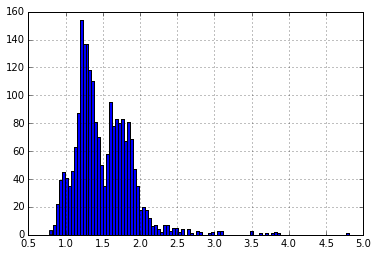

In [81]:
print bracket.var_cost.describe()
np.log(bracket.var_cost + 1).hist(bins=100)

In [90]:
# Get training set only for well-behaved bracket, and only for adj_quantity=250.

X_train, y_train, X_test, y_test = next(generate_xv_splits(aug_train_set))
X_train['log_cost'] = y_train
X_test['log_cost'] = y_test
print X_train.shape, X_test.shape

X_train = X_train[(X_train.bracketing_pattern == brapa) & (X_train.adj_quantity == 250)]
X_test = X_test[(X_test.bracketing_pattern == brapa) & (X_test.adj_quantity == 250)]
print X_train.shape, X_test.shape

y_train = X_train.pop('log_cost')
y_test = X_test.pop('log_cost')

print X_train.adj_quantity.value_counts()
print X_test.adj_quantity.value_counts()
print X_train.bracketing_pattern.value_counts()
print X_test.bracketing_pattern.value_counts()
print X_train.supplier.value_counts()
print X_test.supplier.value_counts()

(27270, 29) (2943, 29)
(1999, 29) (206, 29)
250    1999
dtype: int64
250    206
dtype: int64
(1, 2, 5, 10, 25, 50, 100, 250)    1999
dtype: int64
(1, 2, 5, 10, 25, 50, 100, 250)    206
dtype: int64
S-0066    1999
dtype: int64
S-0066    206
dtype: int64


In [94]:
# Evaluate RF only on examples with adj_quantity=250.

featurizer = AllCategoricalsFeaturizer()
%time featurizer.fit(X_train)
%time X_train_feats = featurizer.transform(X_train)
%time X_test_feats = featurizer.transform(X_test)
X_train_feats.info(verbose=True)

%time X_train_np = X_train_feats.astype(np.float).values
y_train_np = y_train.values
%time X_test_np = X_test_feats.astype(np.float).values
y_test_np = y_test.values

reg = RandomForestRegressor(n_estimators=20)
%time train_rmsle, test_rmsle = eval_regressor(reg, X_train_np, y_train_np, X_test_np, y_test_np)
print "{}:".format(reg)
print "    train RMSLE {}".format(train_rmsle)
print "    test RMSLE {}".format(test_rmsle)
print

CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 37.6 ms
CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 55.4 ms
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 22.3 ms
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 7 to 27223
Data columns (total 101 columns):
annual_usage                                          int64
min_order_quantity                                    int64
bracket_pricing                                       bool
quantity                                              int64
diameter                                              float64
wall_thickness                                        float64
length                                                float64
num_bends                                             int64
bend_radius                                           float64
end_a_1x                                              bool
end_a_2x                                              bool
end_x_1x                    

In [68]:
# Extract pred_var_cost from y_test_pred, which is pred_log_cost for qty=1.

y_test_pred = reg.predict(X_test_np)
print np.sqrt(mean_squared_error(y_test_np, y_test_pred))
df = pd.DataFrame()
df['tube_assembly_id'] = X_test.tube_assembly_id
df['pred_cost_for_qty_1'] = inverse_log_transform_y(y_test_pred)
print df.shape
df = df.merge(bracket)
df['pred_var_cost'] = df.pred_cost_for_qty_1 - df.fixed_cost
print df.shape
df[:5]

0.0676371395344
(206, 2)
(206, 6)


,tube_assembly_id,pred_cost_for_qty_1,fixed_cost_class,fixed_cost,var_cost,pred_var_cost
0,TA-00093,21.573154,1,19.043385,2.528315,2.529769
1,TA-00125,28.501491,3,23.633726,4.912866,4.867765
2,TA-00173,27.700158,2,20.295284,4.370288,7.404874
3,TA-00264,21.422820,1,19.043385,2.396515,2.379435
4,TA-00334,22.291537,1,19.043385,2.396515,3.248152


In [112]:
# Try to predict log(var_cost) directly.

X_train, y_train, X_test, y_test = next(generate_xv_splits(aug_train_set))
X_train['log_cost'] = y_train
X_test['log_cost'] = y_test
print X_train.shape, X_test.shape

X_train = X_train[(X_train.bracketing_pattern == brapa) & (X_train.adj_quantity == 1)]
X_test = X_test[(X_test.bracketing_pattern == brapa) & (X_test.adj_quantity == 1)]
log_cost_train = X_train.pop('log_cost')
log_cost_test = X_test.pop('log_cost')
print X_train.shape, X_test.shape

X_train = X_train.merge(bracket, on='tube_assembly_id')
X_test = X_test.merge(bracket, on='tube_assembly_id')
y_train = log_transform_y(X_train.pop('var_cost'))
y_test = log_transform_y(X_test.pop('var_cost'))
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

featurizer = AllCategoricalsFeaturizer()
%time featurizer.fit(X_train)
%time X_train_feats = featurizer.transform(X_train)
%time X_test_feats = featurizer.transform(X_test)
X_train_feats.info(verbose=True)

%time X_train_np = X_train_feats.astype(np.float).values
y_train_np = y_train.values
%time X_test_np = X_test_feats.astype(np.float).values
y_test_np = y_test.values

reg = RandomForestRegressor(n_estimators=20)
%time train_rmsle, test_rmsle = eval_regressor(reg, X_train_np, y_train_np, X_test_np, y_test_np)
print "{}:".format(reg)
print "    train RMSLE_vc {}".format(train_rmsle)
print "    test RMSLE_vc {}".format(test_rmsle)
print

(27270, 29) (2943, 29)
(1999, 28) (206, 28)
(1999, 30) (206, 30) (1999,) (206,)
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 37.1 ms
CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 65 ms
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 24.9 ms
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 0 to 1998
Data columns (total 103 columns):
annual_usage                                          int64
min_order_quantity                                    int64
bracket_pricing                                       bool
quantity                                              int64
diameter                                              float64
wall_thickness                                        float64
length                                                float64
num_bends                                             int64
bend_radius                                           float64
end_a_1x                                              bool
end_a_2x  

In [116]:
# Extract pred_var_cost for each taid in X_test.

y_test_pred = reg.predict(X_test_np)
print np.sqrt(mean_squared_error(y_test_np, y_test_pred))
df = pd.DataFrame()
df['tube_assembly_id'] = X_test.tube_assembly_id
df = df.merge(bracket, on='tube_assembly_id')
df['pred_var_cost'] = inverse_log_transform_y(y_test_pred)
print df.shape
df[:5]

0.127771671493
(206, 5)


,tube_assembly_id,fixed_cost_class,fixed_cost,var_cost,pred_var_cost
0,TA-00093,1,19.043385,2.528315,2.492828
1,TA-00125,3,23.633726,4.912866,4.783798
2,TA-00173,2,20.295284,4.370288,4.378908
3,TA-00264,1,19.043385,2.396515,2.358751
4,TA-00334,1,19.043385,2.396515,2.393478


In [118]:
# Extrapolate predicted cost for other quantities, assuming true fixed_cost observed.

_, _, X_test_full, y_test_full = next(generate_xv_splits(aug_train_set))
X_test_full['log_cost'] = y_test_full
print X_test_full.shape

X_test_full = X_test_full[X_test_full.bracketing_pattern == brapa]
print X_test_full.shape

X_test_full = X_test_full.merge(df, on='tube_assembly_id')
print X_test_full.shape

X_test_full['pred_cost'] = X_test_full.fixed_cost / X_test_full.adj_quantity + X_test_full.pred_var_cost
X_test_full['pred_log_cost'] = log_transform_y(X_test_full.pred_cost)
X_test_full['err2'] = (X_test_full.log_cost.values - X_test_full.pred_log_cost.values) ** 2
X_test_full.sort('err2', ascending=False, inplace=True)
print X_test_full.shape

print X_test_full.err2.describe()
print np.sqrt(mean_squared_error(X_test_full.log_cost.values, X_test_full.pred_log_cost.values))

X_test_full[:10]

(2943, 29)
(1648, 29)
(1648, 33)
(1648, 36)
count    1.648000e+03
mean     1.062761e-02
std      7.361506e-02
min      9.391643e-11
25%      1.747167e-05
50%      1.855751e-04
75%      1.118387e-03
max      1.266037e+00
Name: err2, dtype: float64
0.10309032305


,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,material_id,diameter,wall_thickness,...,adj_bracketing,bracketing_pattern,log_cost,fixed_cost_class,fixed_cost,var_cost,pred_var_cost,pred_cost,pred_log_cost,err2
375,TA-03006,S-0066,2013-09-01,0,0,True,250,SP-0029,19.05,1.65,...,True,"(1, 2, 5, 10, 25, 50, 100, 250)",3.085035,2,20.295284,20.70167,6.017092,6.098273,1.959852,1.266037
374,TA-03006,S-0066,2013-09-01,0,0,True,100,SP-0029,19.05,1.65,...,True,"(1, 2, 5, 10, 25, 50, 100, 250)",3.089224,2,20.295284,20.70167,6.017092,6.220045,1.976861,1.237351
373,TA-03006,S-0066,2013-09-01,0,0,True,50,SP-0029,19.05,1.65,...,True,"(1, 2, 5, 10, 25, 50, 100, 250)",3.096294,2,20.295284,20.70167,6.017092,6.422998,2.004583,1.191832
372,TA-03006,S-0066,2013-09-01,0,0,True,25,SP-0029,19.05,1.65,...,True,"(1, 2, 5, 10, 25, 50, 100, 250)",3.111524,2,20.295284,20.70167,6.017092,6.828904,2.057822,1.110287
371,TA-03006,S-0066,2013-09-01,0,0,True,10,SP-0029,19.05,1.65,...,True,"(1, 2, 5, 10, 25, 50, 100, 250)",3.164603,2,20.295284,20.70167,6.017092,8.046621,2.202391,0.925852
370,TA-03006,S-0066,2013-09-01,0,0,True,5,SP-0029,19.05,1.65,...,True,"(1, 2, 5, 10, 25, 50, 100, 250)",3.247106,2,20.295284,20.70167,6.017092,10.076149,2.404794,0.709490
1567,TA-20766,S-0066,2013-11-02,1,0,True,250,SP-0029,12.70,0.89,...,True,"(1, 2, 5, 10, 25, 50, 100, 250)",2.979539,3,23.633726,18.49766,8.426227,8.520762,2.253475,0.527169
1566,TA-20766,S-0066,2013-11-02,1,0,True,100,SP-0029,12.70,0.89,...,True,"(1, 2, 5, 10, 25, 50, 100, 250)",2.985178,3,23.633726,18.49766,8.426227,8.662564,2.268259,0.513973
1565,TA-20766,S-0066,2013-11-02,1,0,True,50,SP-0029,12.70,0.89,...,True,"(1, 2, 5, 10, 25, 50, 100, 250)",2.994553,3,23.633726,18.49766,8.426227,8.898901,2.292424,0.492985
1564,TA-20766,S-0066,2013-11-02,1,0,True,25,SP-0029,12.70,0.89,...,True,"(1, 2, 5, 10, 25, 50, 100, 250)",3.014818,3,23.633726,18.49766,8.426227,9.371576,2.339069,0.456637


In [126]:
# Try to predict fixed_cost_class and log(var_cost) independently, then combine the two.

X_train, y_train, X_test, y_test = next(generate_xv_splits(aug_train_set))
X_train['log_cost'] = y_train
X_test['log_cost'] = y_test
print X_train.shape, X_test.shape

X_train = X_train[(X_train.bracketing_pattern == brapa) & (X_train.adj_quantity == 1)]
X_test = X_test[(X_test.bracketing_pattern == brapa) & (X_test.adj_quantity == 1)]
log_cost_train = X_train.pop('log_cost')
log_cost_test = X_test.pop('log_cost')
print X_train.shape, X_test.shape

X_train = X_train.merge(bracket, on='tube_assembly_id')
X_test = X_test.merge(bracket, on='tube_assembly_id')
X_train.pop('fixed_cost')
X_test.pop('fixed_cost')
log_var_cost_train = log_transform_y(X_train.pop('var_cost'))
log_var_cost_test = log_transform_y(X_test.pop('var_cost'))
fcc_train = X_train.pop('fixed_cost_class')
fcc_test = X_test.pop('fixed_cost_class')
print X_train.shape, X_test.shape

featurizer = AllCategoricalsFeaturizer()
%time featurizer.fit(X_train)
%time X_train_feats = featurizer.transform(X_train)
%time X_test_feats = featurizer.transform(X_test)
X_train_feats.info(verbose=True)

%time X_train_np = X_train_feats.astype(np.float).values
%time X_test_np = X_test_feats.astype(np.float).values

(27270, 29) (2943, 29)
(1999, 28) (206, 28)
(1999, 28) (206, 28)
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 35.6 ms
CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 91.5 ms
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 30.2 ms
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 0 to 1998
Data columns (total 101 columns):
annual_usage                                          int64
min_order_quantity                                    int64
bracket_pricing                                       bool
quantity                                              int64
diameter                                              float64
wall_thickness                                        float64
length                                                float64
num_bends                                             int64
bend_radius                                           float64
end_a_1x                                              bool
end_a_2x               

In [136]:
# The classification part: predict fixed_cost_class.

y_train = fcc_train
y_test = fcc_test
y_train_np = y_train.values
y_test_np = y_test.values

clf = RandomForestClassifier(n_estimators=100)
%time clf.fit(X_train_np, y_train_np)
y_train_pred = clf.predict(X_train_np)
print "on train:"
print clf.score(X_train_np, y_train_np)
print confusion_matrix(y_train_np, y_train_pred)

y_test_pred = clf.predict(X_test_np)
pred_fixed_cost_class_test = y_test_pred

print
print "on test:"
print clf.score(X_test_np, y_test_np)
print confusion_matrix(y_test_np, y_test_pred)

print
print "feature importances:"
print_feature_importances(X_train_feats, clf);

CPU times: user 484 ms, sys: 0 ns, total: 484 ms
Wall time: 516 ms
on train:
0.99899949975
[[  30    0    0    0]
 [   0 1179    0    0]
 [   0    0  227    1]
 [   0    1    0  561]]

on test:
0.917475728155
[[  2   1   0   0]
 [  0 136   0   4]
 [  0   2  22   5]
 [  0   2   3  29]]

feature importances:
length 0.0894820200844
wall_thickness 0.0697350846985
end_x EF-003 0.0500884798817
diameter 0.0464542880704
end_a EF-003 0.0437021136247
material_id SP-0029 0.0436367980116
quote_age 0.0428914689403
num_bends 0.0407594604288
components other 0.0405959715093
bend_radius 0.0363907329378
components C-1631 0.0272862255114
components C-1624 0.0256983858577
components C-1621 0.025370912373
end_x EF-008 0.022712159098
components C-1629 0.0226766530461
end_a EF-008 0.022641447701
components C-1632 0.0201046578161
end_a_2x 0.0196720573343
components C-1622 0.0194165958429
components C-1623 0.0184972111659
components C-1630 0.0178326423712
end_x_2x 0.0154716345103
components C-1638 0.015185197

In [139]:
# The regression part: predict var_cost.

y_train = log_var_cost_train
y_test = log_var_cost_test
y_train_np = y_train.values
y_test_np = y_test.values

reg = RandomForestRegressor(n_estimators=20)
%time train_rmsle, test_rmsle = eval_regressor(reg, X_train_np, y_train_np, X_test_np, y_test_np)
print "{}:".format(reg)
print "    train RMSLE_vc {}".format(train_rmsle)
print "    test RMSLE_vc {}".format(test_rmsle)
print

y_test_pred = reg.predict(X_test_np)
pred_log_var_cost_test = y_test_pred

CPU times: user 708 ms, sys: 4 ms, total: 712 ms
Wall time: 723 ms
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False):
    train RMSLE_vc 0.0690357381268
    test RMSLE_vc 0.150964391798



In [141]:
pred_log_var_cost_test

array([ 1.25510732,  1.76479342,  1.67127429,  1.21585232,  1.22183107,
        1.28498987,  1.26808052,  1.19901911,  1.44166051,  1.35271189,
        1.82371569,  1.27878921,  1.5325906 ,  1.45323163,  1.19430352,
        1.13373326,  1.09149838,  1.08866807,  1.36625882,  1.29316202,
        1.19370247,  1.22671212,  1.30525959,  1.64416158,  1.46805841,
        1.72779512,  2.0982482 ,  1.3060855 ,  1.25877572,  1.49017955,
        1.49569148,  1.68164557,  2.02136207,  0.95520805,  1.71225647,
        1.82119967,  1.50905174,  1.67468686,  1.88742237,  1.30053819,
        1.19429464,  1.67102208,  1.28709567,  1.33989942,  1.2350144 ,
        1.55749239,  1.95859896,  1.50328213,  1.64466444,  1.31170212,
        2.38244723,  1.79726144,  1.50311547,  1.2373287 ,  1.18563642,
        1.26045989,  1.40602467,  1.30840396,  1.30769779,  1.46625918,
        2.13475421,  1.88321349,  1.64075684,  1.18231747,  1.3286897 ,
        1.73044906,  1.30728962,  1.31184127,  1.26312332,  1.28

In [148]:
# Combine predictions.

print accuracy_score(fcc_test, pred_fixed_cost_class_test)
print np.sqrt(mean_squared_error(log_var_cost_test, pred_log_var_cost_test))
df = pd.DataFrame()
df['tube_assembly_id'] = X_test.tube_assembly_id
df['pred_fixed_cost_class'] = pred_fixed_cost_class_test
df['pred_fixed_cost'] = np.array(fc_vals)[df.pred_fixed_cost_class]
df['pred_var_cost'] = inverse_log_transform_y(pred_log_var_cost_test)
print df.shape
df[:5]

0.917475728155
0.150964391798
(206, 4)


,tube_assembly_id,pred_fixed_cost_class,pred_fixed_cost,pred_var_cost
0,TA-00093,1,19.043385,2.508215
1,TA-00125,3,23.633726,4.840366
2,TA-00173,2,20.295284,4.318941
3,TA-00264,1,19.043385,2.373168
4,TA-00334,1,19.043385,2.393396


In [150]:
# Evaluate on all quantities.

_, _, X_test_full, y_test_full = next(generate_xv_splits(aug_train_set))
X_test_full['log_cost'] = y_test_full
print X_test_full.shape

X_test_full = X_test_full[X_test_full.bracketing_pattern == brapa]
print X_test_full.shape

X_test_full = X_test_full.merge(bracket, on='tube_assembly_id')
X_test_full = X_test_full.merge(df, on='tube_assembly_id')
print X_test_full.shape

X_test_full['pred_cost'] = X_test_full.pred_fixed_cost / X_test_full.adj_quantity + X_test_full.pred_var_cost
X_test_full['pred_log_cost'] = log_transform_y(X_test_full.pred_cost)
X_test_full['err2'] = (X_test_full.log_cost.values - X_test_full.pred_log_cost.values) ** 2
X_test_full.sort('err2', ascending=False, inplace=True)
print X_test_full.shape

print X_test_full.err2.describe()
print np.sqrt(mean_squared_error(X_test_full.log_cost.values, X_test_full.pred_log_cost.values))

X_test_full[:10]

(2943, 29)
(1648, 29)
(1648, 35)
(1648, 38)
count    1.648000e+03
mean     1.534164e-02
std      7.813045e-02
min      9.197638e-12
25%      3.764836e-05
50%      3.229354e-04
75%      2.959388e-03
max      1.243336e+00
Name: err2, dtype: float64
0.123861365099


,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,material_id,diameter,wall_thickness,...,log_cost,fixed_cost_class,fixed_cost,var_cost,pred_fixed_cost_class,pred_fixed_cost,pred_var_cost,pred_cost,pred_log_cost,err2
375,TA-03006,S-0066,2013-09-01,0,0,True,250,SP-0029,19.05,1.65,...,3.085035,2,20.295284,20.70167,2,20.295284,6.089388,6.170569,1.969985,1.243336
374,TA-03006,S-0066,2013-09-01,0,0,True,100,SP-0029,19.05,1.65,...,3.089224,2,20.295284,20.70167,2,20.295284,6.089388,6.292340,1.986825,1.215285
373,TA-03006,S-0066,2013-09-01,0,0,True,50,SP-0029,19.05,1.65,...,3.096294,2,20.295284,20.70167,2,20.295284,6.089388,6.495293,2.014275,1.170764
372,TA-03006,S-0066,2013-09-01,0,0,True,25,SP-0029,19.05,1.65,...,3.111524,2,20.295284,20.70167,2,20.295284,6.089388,6.901199,2.067015,1.091000
371,TA-03006,S-0066,2013-09-01,0,0,True,10,SP-0029,19.05,1.65,...,3.164603,2,20.295284,20.70167,2,20.295284,6.089388,8.118916,2.210351,0.910597
370,TA-03006,S-0066,2013-09-01,0,0,True,5,SP-0029,19.05,1.65,...,3.247106,2,20.295284,20.70167,2,20.295284,6.089388,10.148444,2.411300,0.698572
1567,TA-20766,S-0066,2013-11-02,1,0,True,250,SP-0029,12.70,0.89,...,2.979539,3,23.633726,18.49766,2,20.295284,7.809073,7.890254,2.184956,0.631363
1566,TA-20766,S-0066,2013-11-02,1,0,True,100,SP-0029,12.70,0.89,...,2.985178,3,23.633726,18.49766,2,20.295284,7.809073,8.012026,2.198560,0.618768
1565,TA-20766,S-0066,2013-11-02,1,0,True,50,SP-0029,12.70,0.89,...,2.994553,3,23.633726,18.49766,2,20.295284,7.809073,8.214979,2.220830,0.598647
1564,TA-20766,S-0066,2013-11-02,1,0,True,25,SP-0029,12.70,0.89,...,3.014818,3,23.633726,18.49766,2,20.295284,7.809073,8.620885,2.263936,0.563824
